In [ ]:
import numpy as np
import pandas as pd
import pylab as plt 

from google.colab import drive
import sqlite3
import seaborn as sns

from scipy.stats import binned_statistic, binned_statistic_2d
from scipy.stats import randint as sp_randint , uniform

from matplotlib.colors import BoundaryNorm, LogNorm
from statsmodels.stats.proportion import proportion_confint

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc , confusion_matrix
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, fbeta_score, make_scorer, auc

from inspect import signature

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.manifold import TSNE

import pickle

In [67]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
out=pickle.load(  open( "/content/gdrive/My Drive/UD/Sbux/data/out.pkl", "rb" ) )

In [ ]:
out=out.loc[ (out.offer_type !='informational') ]
out['overlaps']=out['overlaps'].fillna(0)

In [6]:
display(out.columns)

Index(['person', 'offer', 'offer_received', 'offer_viewed', 'offer_completed',
       'reward', 'offer_end', 'difficulty', 'duration', 'offer_type', 'web',
       'email', 'mobile', 'social', 'offer_reward', 'duration_hours',
       'duration_viewed', 'duration_effective', 'viewed', 'rewarded',
       'received', 'comp_not_viewed', 'completed', 'Tpay_offer', 'Npay_offer',
       'Maxpay_offer', 'Minpay_offer', 'Netpay_offer', 'Avg_pay_offer', 'age',
       'became_member_on', 'gender', 'income', 'joined_year', 'joined_month',
       'joined_week', 'gender_num', 'user_time', 'Tpay_out', 'Npay_out',
       'p_c_r_ratio', 'p_cnv_r_ratio', 'overlaps', 'Tpay_offers_tot',
       'Npay_offers_tot', 'Maxpay_offers_tot', 'Minpay_offers_tot',
       'Trewards_tot', 'Nrewards_tot', 'tot_gross_offer_time',
       'tot_net_offers_time', 'tot_not_offers_time', 'Avg_pay_offers',
       'Net_pay_offers', 'Avg_net_pay_offers', 'Avg_pay_outside', 'Avg_D_O',
       'Avg_D_OS'],
      dtype='object')

In [ ]:
def prepareXY_comp_not_viewed(piv4,drop_person=True):

  if drop_person:
    col_cat=['offer_type', 'gender'] 
    col_drop_optional=['offer', 'person']
  else:
    col_cat=['offer_type', 'gender' ,'person']
    col_drop_optional=['offer'] 
    
  col_bin=['web',  'mobile', 'social' ]


  col_drop=[ 'joined_year', 'joined_month', 'joined_week', 'gender_num',
            'became_member_on', 'email','received']

  col_drop_leak=[ 'offer_viewed','offer_completed', 'reward','Avg_pay_offer','Avg_pay_offers','Npay_offer','Tpay_offer',
                 'Maxpay_offer', 'Minpay_offer', 'Netpay_offer','duration_viewed', 'Maxpay_offers_tot', 'Minpay_offers_tot',
                 'Trewards_tot', 'Nrewards_tot','Avg_net_pay_offers','Net_pay_offers',
            'duration_effective', 'viewed','rewarded', 'comp_not_viewed'	, 'completed', 'Avg_D_O','Avg_D_OS','p_cnv_r_ratio','p_c_r_ratio',
                 'Tpay_offers_tot','Npay_offers_tot', 'tot_gross_offer_time','tot_net_offers_time','tot_not_offers_time' ,'overlaps' ]
  col_drop_do_not_affect=['difficulty','duration','offer_end']


  
  # Y_col=['viewed', 'rewarded', 'comp_not_viewed',  'completed']
  Y_col=piv4['comp_not_viewed'].astype(int)
  drop_all=col_drop+col_drop_optional+col_drop_leak+col_drop_do_not_affect
  
  piv5=(piv4.copy()).drop(columns=drop_all)
  
  # imputing missing values
  piv5.loc[piv5['income'].isnull(),'income']=piv5['income'].mean(skipna=True)
  piv5[col_bin]=piv5[col_bin].astype(int)
    
  X_onehot=pd.get_dummies(piv4[col_cat])
  col_oneh=X_onehot.columns
  
  col_numbin=list(set(piv5.columns)-set(col_cat))
  
  X=pd.concat((piv5[col_numbin],X_onehot),axis=1)
  
  return(X,Y_col)

def apply_scaling(X,scaler,col_scale):
  X_scaled=scaler.transform(X[col_scale])
  X_scaled=pd.DataFrame(X_scaled,columns=col_scale,index=X.index)
  
  other_cols=set(X.columns)-set(col_scale)
  X2=pd.concat((X_scaled,X[other_cols]),axis=1)
  return(X2)

In [ ]:
def prepareXY_cluster(piv4,drop_person=True):

  if drop_person:
    col_cat=['offer_type', 'gender'] 
    col_drop_optional=['offer', 'person']
  else:
    col_cat=['offer_type', 'gender' ,'person']
    col_drop_optional=['offer'] 
    
  col_bin=['web',  'mobile', 'social' ]


  col_drop=[ 'joined_year', 'joined_month', 'joined_week', 'gender_num',
            'became_member_on', 'email','received']

  col_drop_leak=[ 'offer_viewed','offer_completed', 'reward','Avg_pay_offer','Avg_pay_offers','Npay_offer','Tpay_offer','duration_viewed',
            'duration_effective', 'viewed','rewarded', 'comp_not_viewed'	, 'completed', 'Avg_D_O','Avg_D_OS','p_cnv_r_ratio','p_c_r_ratio',
                 'Tpay_offers_tot','Npay_offers_tot', 'tot_gross_offer_time','tot_net_offers_time','tot_not_offers_time' ,'overlaps' ]
  col_drop_do_not_affect=['difficulty','duration','offer_end']


  
  # Y_col=['viewed', 'rewarded', 'comp_not_viewed',  'completed']
#   Y_col=piv4['comp_not_viewed'].astype(int)
  drop_all=col_drop_optional+col_drop
  piv5=(piv4.copy()).drop(columns=drop_all)
  
  # imputing missing values
  piv5.loc[piv5['income'].isnull(),'income']=piv5['income'].mean(skipna=True)
  piv5[col_bin]=piv5[col_bin].astype(int)
    
  X_onehot=pd.get_dummies(piv4[col_cat])
  col_oneh=X_onehot.columns
  
  col_numbin=list(set(piv5.columns)-set(col_cat))
  
  X=pd.concat((piv5[col_numbin],X_onehot),axis=1)
  
  return(X)


In [ ]:
X,y =  prepareXY_comp_not_viewed(out,drop_person=True)
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=0)

col_scale=['Tpay_out', 'income',  'offer_received', 'Npay_out', 'user_time', 'Avg_pay_outside', 'age']
scaler=StandardScaler()
scaler.fit(X_train[col_scale])


X2_train=apply_scaling(X_train,scaler,col_scale)
X2_test=apply_scaling(X_test,scaler,col_scale)


In [ ]:
def cm_score(y_test,y_pred,c_fn,c_fp):
  
  cm=confusion_matrix(y_test, y_pred)
  tn, fp, fn, tp =cm.ravel()
  score=-c_fn*fn - c_fp*fp
  return(score)

def cm_score_manual(y_test,y_pred,reward=None,loss_of_revenue_per_hour=None,duration=None):
  # custom scorer that calculates the economic cost of each false positive and negative basend
  # on the specific characteristics of the offer
  
  ind=y_test.index
  
  fn = ((y_test==True)  & (y_pred==False)).astype(int)
  fp = ((y_test==False) & (y_pred==True )).astype(int)
  
  fn=fn.astype(int)
  fp=fp.astype(int)
   
  cost_fn=-reward.loc[ind].values
  cost_fp=-loss_of_revenue_per_hour* duration.loc[ind]
  
  
  score= np.sum(cost_fn*fn) + np.sum( cost_fp*fp )
  
  return(score)


In [ ]:
# scoring_cm_std = make_scorer(cm_score, c_fn=100, c_fp=2, greater_is_better=True)
scoring_cm_manual = make_scorer(cm_score_manual, reward=X_train['offer_reward'],loss_of_revenue_per_hour= 0.12,duration=X_train['duration_hours'] , greater_is_better=True)


In [183]:


# specify parameters and distributions to sample from
param_dist = {
              "n_estimators": sp_randint(1, 40),
              "max_depth": [3, None],
              "max_features": sp_randint(1, 15),
              #"max_features": uniform(0.1, 1.),
              #"max_features": ["auto","log2"],
              "min_samples_split": sp_randint(2, 20),
            }

# run randomized search
n_iter_search = 20
clf = RandomForestClassifier( bootstrap=20, criterion="entropy",class_weight="balanced")
#random_search = RandomizedSearchCV(clf,scoring='average_precision', param_distributions=param_dist,  cv=5, iid=False)
random_search = RandomizedSearchCV(clf,scoring=scoring_cm_manual, param_distributions=param_dist,  cv=5, iid=False, n_iter=30)



random_search.fit(X2_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=20,
                                                    class_weight='balanced',
                                                    criterion='entropy',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jo

In [184]:
sorted(random_search.cv_results_.keys())
display(random_search.cv_results_['mean_test_score'])
clf=random_search.best_estimator_

array([-50880.792, -51020.48 , -50825.912, -54521.296, -18020.848,
       -51967.816, -53147.136, -17784.824, -13774.04 , -13280.584,
       -51374.624, -51242.064, -50836.68 , -17420.984, -13950.224,
       -17189.376, -50854.136, -14627.712, -13461.832, -51249.952,
       -13795.896, -11108.992, -14941.912,  -9346.8  , -16819.   ,
       -53105.752, -50842.04 ,  -6371.08 , -12999.8  , -50840.44 ])

Text(0, 0.5, '$ cost of misclassification')

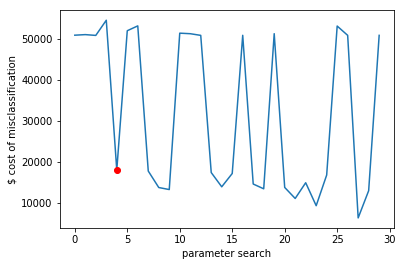

In [185]:
plt.plot(-random_search.cv_results_['mean_test_score'])
plt.plot(4,-random_search.cv_results_['mean_test_score'][4],'ro')
plt.xlabel('parameter search')
plt.ylabel('$ cost of misclassification')



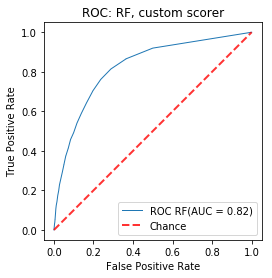

In [194]:
clf.fit(X2_train,y_train)
probas_ = clf.predict_proba(X2_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])

roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, alpha=1, label='ROC RF(AUC = %0.2f)' % (roc_auc));
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: RF, custom scorer')
plt.legend(loc="lower right");
plt.axis('square');

In [199]:
score_do_nothing=cm_score_manual(y_test,clf.predict(X2_test), reward=X_test['offer_reward'],loss_of_revenue_per_hour= 0.12,duration=0.6*X_test['duration_hours'])
print(score_do_nothing)

-10190.136


In [197]:
display(confusion_matrix(y_test, clf.predict(X2_test)))
display(confusion_matrix(y_test, 0*y_test))


array([[16394,   249],
       [ 1433,   237]])

array([[16643,     0],
       [ 1670,     0]])

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.10')

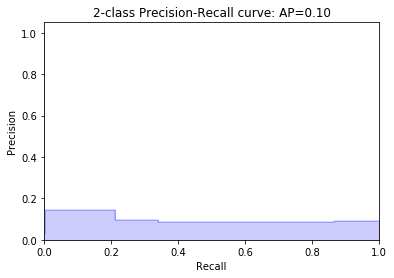

In [177]:


#y_score = clf.decision_function(X_test)
# y_score = clf.predict(X_test)
y_score = clf.predict_proba(X_test)[:,1]

average_precision = average_precision_score(y_test, y_score)

precision, recall, _ = precision_recall_curve(y_test, y_score)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

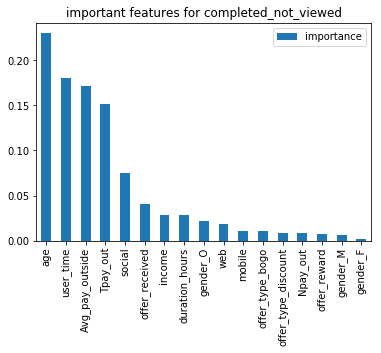

In [178]:
feat=pd.DataFrame.from_dict(dict(zip(X.columns,clf.feature_importances_) ), orient='index',columns=['importance'])
feat=feat.sort_values(by=['importance'],ascending=False)
feat.plot(kind='bar');
plt.title('important features for completed_not_viewed');

In [ ]:
clf

RandomForestClassifier(bootstrap=20, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=10, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=9,
                       min_weight_fraction_leaf=0.0, n_estimators=21,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [166]:
from sklearn.tree import DecisionTreeClassifier

# specify parameters and distributions to sample from
param_dist = {
              "max_depth": sp_randint(2, 50),
              "max_features": sp_randint(1, 15),
              #"max_features": uniform(0.1, 1.),
              #"max_features": ["auto","log2"],
              "min_samples_split": uniform(.1, .9),
    
            }

# run randomized search
n_iter_search = 20
clf = DecisionTreeClassifier(  criterion="entropy",class_weight="balanced")
#clf = DecisionTreeClassifier(  criterion="entropy",class_weight={0:1,1:10})
#random_search = RandomizedSearchCV(clf, scoring='average_precision', param_distributions=param_dist,  cv=5, iid=False)
random_search = RandomizedSearchCV(clf, scoring=scoring_cm_manual, param_distributions=param_dist,  cv=5, iid=False,n_iter=100)



random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    criterion='entropy',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort=False,
                                                    random_state=None,
                                                    splitte

In [ ]:
#random_search.cv_results_

In [167]:
sorted(random_search.cv_results_.keys())
display(random_search.cv_results_['mean_test_score'])
clf=random_search.best_estimator_

array([ -90530.032,  -76809.512,  -53815.232,  -56993.008,  -59852.104,
        -59852.104,  -54910.584,  -84451.696,  -97463.696,  -57970.648,
        -58642.472,  -76239.472,  -59852.104,  -53314.672,  -63766.152,
        -75197.768,  -69805.408,  -58071.856,  -88418.432,  -54515.656,
        -54499.272,  -76007.208,  -59852.104,  -59852.104,  -54671.04 ,
        -69891.4  ,  -59852.104,  -51162.28 ,  -87978.456, -102081.736,
        -95533.24 ,  -77560.632,  -58078.208,  -54557.456,  -66446.48 ,
        -53090.696,  -73663.024,  -52568.528,  -58155.608,  -66800.04 ,
        -60266.024,  -64124.832,  -74972.776,  -58594.848,  -59852.104,
        -67639.448,  -73922.968,  -56505.744,  -59852.104,  -62126.528,
        -63641.624,  -59852.104,  -58283.   ,  -59852.104,  -68699.512,
        -94970.536,  -59852.104, -116300.216,  -54557.456,  -60266.024,
        -67541.16 ,  -62417.768,  -53848.248,  -76904.952,  -58548.576,
        -58457.8  ,  -69471.416,  -50825.912,  -71966.528,  -598

Text(0, 0.5, '$ cost of misclassification')

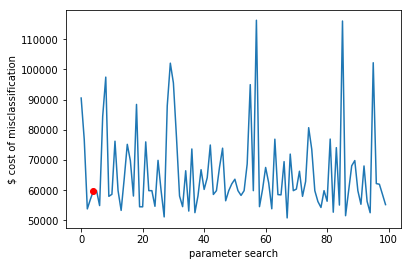

In [168]:
plt.plot(-random_search.cv_results_['mean_test_score'])
plt.plot(4,-random_search.cv_results_['mean_test_score'][4],'ro')
plt.xlabel('parameter search')
plt.ylabel('$ cost of misclassification')

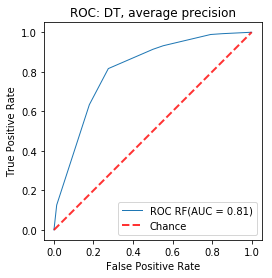

In [169]:
clf.fit(X_train,y_train)
probas_ = clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])

roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, alpha=1, label='ROC RF(AUC = %0.2f)' % (roc_auc));
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: DT, average precision')
plt.legend(loc="lower right");
plt.axis('square');

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.26')

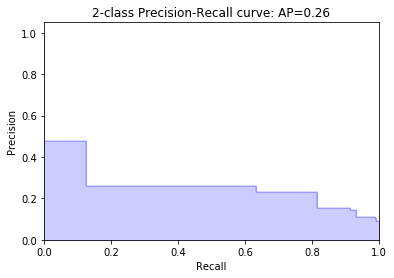

In [170]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from inspect import signature

#y_score = clf.decision_function(X_test)
# y_score = clf.predict(X_test)
y_score = clf.predict_proba(X_test)[:,1]

average_precision = average_precision_score(y_test, y_score)

precision, recall, _ = precision_recall_curve(y_test, y_score)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

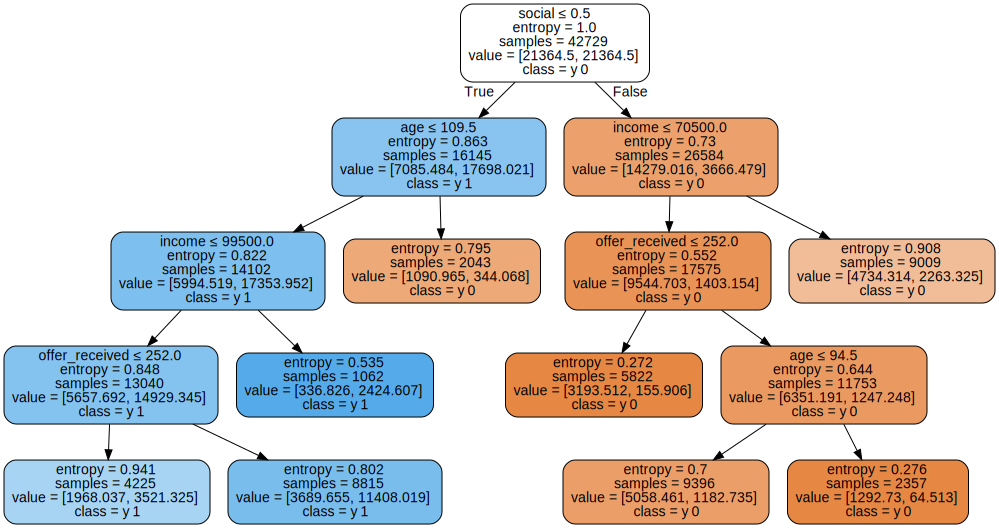

In [171]:
from sklearn import tree
import graphviz 

#plt.figure(figsize=(10,10))
#tree.plot_tree(clf ); 

dot_data = tree.export_graphviz(clf, out_file=None,   feature_names=X_test.columns,
                                class_names=True,
                                #class_names=['other',"comp. not view"],  
  filled=True, rounded=True,  special_characters=True)  
graph = graphviz.Source(dot_data)  
graph
#graph.view() 
#graph.render(filename='/content/gdrive/My Drive/UD/Sbux/dt_g.png',format='png')

#plt.savefig('graph.png')
#plt.show()

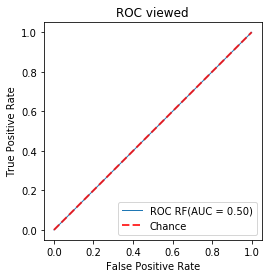

In [191]:
clf.fit(X_train,y_train)
probas_ = clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, 0*probas_[:, 1])

roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, alpha=1, label='ROC RF(AUC = %0.2f)' % (roc_auc));
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC viewed')
plt.legend(loc="lower right");
plt.axis('square');

In [193]:
score_do_nothing=cm_score_manual(y_test,0*y_test, reward=X_test['offer_reward'],loss_of_revenue_per_hour= 0.12,duration=X_test['duration_hours'])
print(score_do_nothing)

-7716.0


In [ ]:
out.head()

,person,offer,offer_received,offer_viewed,offer_completed,reward,offer_end,difficulty,duration,offer_type,web,email,mobile,social,offer_reward,duration_hours,duration_viewed,duration_effective,viewed,rewarded,received,comp_not_viewed,completed,Tpay_out,Npay_out,Tpay_offers_tot,Npay_offers_tot,Tpay_offer,Npay_offer,tot_gross_offer_time,tot_net_offers_time,tot_not_offers_time,age,became_member_on,gender,income,joined_year,joined_month,joined_week,gender_num,user_time,Avg_pay_offer,Avg_pay_offers,Avg_pay_outside,Avg_D_O,Avg_D_OS
0,78afa995795e4d85b5d9ceeca43f5fef,g,0,6.0,132.0,5.0,168.0,5,7,bogo,True,True,True,False,5,168.0,162.0,162.0,True,True,True,False,True,0.00,0.0,135.34,6.0,37.67,2.0,396.0,400.0,344.0,75,2017-05-09,F,100000.0,2017,5,19,0,443,0.232531,0.338350,0.000000,0.232531,0.338350
1,ebe7ef46ea6f4963a7dd49f501b26779,g,0,NaN,NaN,0.0,168.0,5,7,bogo,True,True,True,False,5,168.0,0.0,0.0,False,False,True,False,False,52.08,13.0,49.17,11.0,0.00,0.0,390.0,297.0,447.0,59,2015-01-21,M,41000.0,2015,1,4,1,1282,0.000000,0.165556,0.116510,-0.116510,0.049045
2,f082d80f0aac47a99173ba8ef8fc1909,g,0,48.0,12.0,5.0,168.0,5,7,bogo,True,True,True,False,5,168.0,120.0,120.0,True,True,True,False,True,40.94,14.0,24.86,9.0,14.64,4.0,402.0,327.0,417.0,40,2016-07-09,M,33000.0,2016,7,27,1,747,0.122000,0.076024,0.098177,0.023823,-0.022153
3,c0d210398dee4a0895b24444a5fcd1d2,g,0,30.0,66.0,5.0,168.0,5,7,bogo,True,True,True,False,5,168.0,138.0,138.0,True,True,True,False,True,0.00,0.0,54.05,7.0,6.01,1.0,570.0,482.0,262.0,45,2018-07-07,M,33000.0,2018,7,27,1,19,0.043551,0.112137,0.000000,0.043551,0.112137
4,57dd18ec5ddc46828afb81ec5977bef2,g,0,NaN,NaN,0.0,168.0,5,7,bogo,True,True,True,False,5,168.0,0.0,0.0,False,False,True,False,False,0.00,0.0,219.54,8.0,0.00,0.0,492.0,453.0,291.0,54,2017-02-07,F,80000.0,2017,2,6,0,534,0.000000,0.484636,0.000000,0.000000,0.484636


In [ ]:
def cmp_hist4(out,var):
  
  cnv= ( (out.rewarded==True)  & (  out.viewed==True )  )
  out.loc[cnv,var].hist(bins=50,histtype='step',lw=2,label='compl. & viewed',density=True,alpha=0.5);

  cnv= ( (out.rewarded==True)  & (  out.viewed==False )  )
  out.loc[cnv,var].hist(bins=50,histtype='step',lw=2,label='compl. not viewed',density=True,alpha=0.5);
  
  cnv= ( (out.rewarded==False)  & (  out.viewed==True )  )
  out.loc[cnv,var].hist(bins=50,histtype='step',lw=2,label='not compl. & viewed',density=True,alpha=0.5);

  cnv= ( (out.rewarded==False)  & (  out.viewed==False )  )
  out.loc[cnv,var].hist(bins=50,histtype='step',lw=2,label='not compl. & not viewed',density=True,alpha=0.5);
  
  
  plt.legend(loc=1);
  plt.title(var);

In [ ]:
def cmp_hist(out,var):
  
  cnv= ( (out.rewarded==True)  & (  out.viewed==True )  )
  out.loc[cnv,var].hist(bins=50,histtype='step',lw=2,label='compl. & viewed',density=True,alpha=0.5);

  cnv= ( (out.rewarded==True)  & (  out.viewed==False )  )
  out.loc[cnv,var].hist(bins=50,histtype='step',lw=2,label='compl. not viewed',density=True,alpha=0.5);
  plt.legend(loc=1);
  plt.title(var);

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


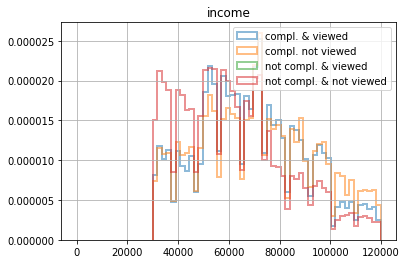

In [ ]:
cmp_hist4(out,'income')

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


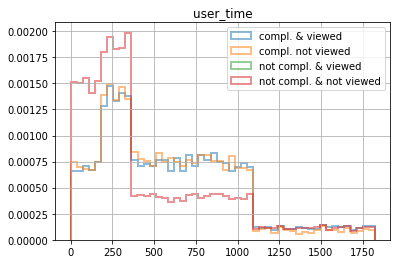

In [ ]:
cmp_hist4(out,'user_time')

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


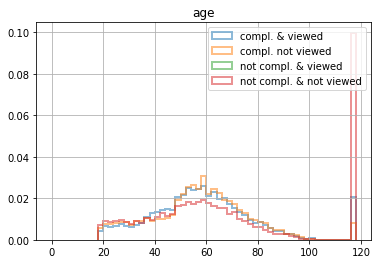

In [ ]:
cmp_hist4(out,'age')

In [ ]:
var='social'
out.loc[out.rewarded==True].groupby(by="viewed")[var].value_counts(normalize=True)

viewed  social
False   False     0.831008
        True      0.168992
True    True      0.747141
        False     0.252859
Name: social, dtype: float64

In [ ]:
var='gender'
out.loc[out.rewarded==True].groupby(by="viewed")[var].value_counts(normalize=True)

viewed  gender
False   F         0.510600
        M         0.481204
        O         0.008195
True    M         0.513307
        F         0.469756
        O         0.016937
Name: gender, dtype: float64

In [ ]:
cnv= ( (out.rewarded==True)  & (  out.viewed==True )  )
out.loc[cnv,'social'].value_counts()



True     20843
False     7054
Name: social, dtype: int64

In [ ]:
cnv= ( (out.rewarded==True)  & (  out.viewed==False )  )
out.loc[cnv,'social'].value_counts()

False    4765
True      969
Name: social, dtype: int64

In [ ]:
col_scale=['Tpay_out', 'income',  'offer_received', 'Npay_out', 'user_time', 'Avg_pay_outside', 'age']
scaler=StandardScaler()

scaler.fit(X_train[col_scale])


def apply_scaling(X,scaler,col_scale):
  X_scaled=scaler.transform(X[col_scale])
  X_scaled=pd.DataFrame(X_scaled,columns=col_scale,index=X.index)
  
  other_cols=set(X.columns)-set(col_scale)
  X2=pd.concat((X_scaled,X[other_cols]),axis=1)
  return(X2)


In [ ]:
X2_train=apply_scaling(X_train,scaler,col_scale)
X2_test=apply_scaling(X_test,scaler,col_scale)


In [ ]:
X2_train.head()

,Tpay_out,income,offer_received,Npay_out,user_time,Avg_pay_outside,age,offer_type_bogo,gender_O,web,mobile,gender_F,gender_M,social,offer_type_discount
9905,-0.383536,-1.552600,-0.390355,-0.382812,-0.392713,-0.382760,-0.382864,0,0,1,0,0,1,0,1
8937,-0.383536,2.158132,-0.398092,-0.382812,-0.367036,-0.382760,-0.382726,0,0,1,0,0,1,0,1
62098,-0.383536,-0.909407,-0.398092,-0.382812,-0.390404,-0.382760,-0.383965,1,0,0,1,1,0,1,0
48893,-0.383536,-1.552600,-0.382618,-0.382812,-0.390681,-0.382760,-0.382176,0,0,1,1,0,1,1,1
50613,2.612618,-0.000446,2.612535,2.612628,2.612202,2.612628,2.612627,0,0,65371,65371,0,0,65371,1


In [ ]:

# specify parameters and distributions to sample from
param_dist = {
              "C": uniform(0.01, 1),
              "degree": sp_randint(1, 3),
              
    
            }

# run randomized search
n_iter_search = 10
# clf = LogisticRegression(random_state=42,solver="saga")
clf = SVC(random_state=42 , kernel = "linear",probability =True)
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,  cv=5, iid=False)

random_search.fit(X2_train, y_train)

KeyboardInterrupt: ignored

In [ ]:
sorted(random_search.cv_results_.keys())
display(random_search.cv_results_['mean_test_score'])
SVCclf=random_search.best_estimator_

In [ ]:
SVCclf.fit(X2_train,y_train)
probas_ = SVCclf.predict_proba(X2_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])

roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, alpha=1, label='ROC SVC(AUC = %0.2f)' % (roc_auc));
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC viewed')
plt.legend(loc="lower right");
plt.axis('square');

In [ ]:


# specify parameters and distributions to sample from
param_dist = {
              "C": uniform(0.01, 1),
              "penalty": ['l2']
            }

# run randomized search
n_iter_search = 10
# clf = LogisticRegression(random_state=42,solver="saga")
clf = LogisticRegression(random_state=42,solver="lbfgs")
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,  cv=5, iid=False)

random_search.fit(X2_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


KeyboardInterrupt: ignored

In [ ]:
# clf = LogisticRegression(C=0.8,random_state=42, penalty="l1",solver="saga",max_iter=200)

In [ ]:
sorted(random_search.cv_results_.keys())
display(random_search.cv_results_['mean_test_score'])
LRclf=random_search.best_estimator_

array([0.90561446, 0.90561446, 0.90561446, 0.90561446, 0.90561446,
       0.90561446, 0.90561446, 0.90561446, 0.90561446, 0.90561446])

In [ ]:
LRclf

LogisticRegression(C=0.6027753801353715, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

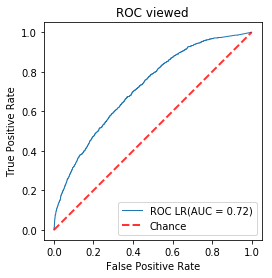

In [ ]:
LRclf.fit(X2_train,y_train)
probas_ = LRclf.predict_proba(X2_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])

roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, alpha=1, label='ROC LR(AUC = %0.2f)' % (roc_auc));
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC viewed')
plt.legend(loc="lower right");
plt.axis('square');